

imports and data download



In [ ]:
!git clone https://github.com/hexiangnan/neural_collaborative_filtering.git
!git clone https://github.com/ChicagoBoothML/DATA___MovieLens___1M.git

fatal: destination path 'neural_collaborative_filtering' already exists and is not an empty directory.
fatal: destination path 'DATA___MovieLens___1M' already exists and is not an empty directory.


In [ ]:
#general
import os
from tqdm import tqdm
from time import time

# DS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Embedding,Linear
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset as TorchDataset

In [ ]:
# globals
DATAPATH = os.path.join("neural_collaborative_filtering", "Data")
TRAIN = os.path.join(DATAPATH, "ml-1m.train.rating")
TEST = os.path.join(DATAPATH, 'ml-1m.test.rating')
NEG = os.path.join(DATAPATH, 'ml-1m.test.negative')

USER_DATA = os.path.join("DATA___MovieLens___1M", "users.dat")
MOVIE_DATA = os.path.join("DATA___MovieLens___1M", "movies.dat")

# configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(42)
print(device)

cuda


# Preprocessing

- take code from NeuMF HW 3
- add history watch per user 
- sort train by timestamp
- example age

In [ ]:
df = pd.read_csv(TRAIN, sep = '\t').set_axis(['user', 'item', 'rating', 'timestamp'], axis = 1, inplace = False)
df = df.sort_values(by = ['user', 'timestamp'], ascending = True)
hist = df.groupby('user')['item'].apply(list).rename('history').to_list()
gradual_hist = []
window = 10
clip = lambda arr: (10 - len(arr)) * [0] + arr if len(arr) < window else arr[len(arr)-10:]
for arr in hist:
  gradual_hist.extend([clip(arr[:i]) for i in range(len(arr))])

df['history'] = gradual_hist

/tmp/ipykernel_613/2567968391.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = pd.read_csv(TRAIN, sep = '\t').set_axis(['user', 'item', 'rating', 'timestamp'], axis = 1, inplace = False)


In [ ]:
user_data_df = pd.read_csv(USER_DATA, sep = '::', header=None).set_axis(['user', 'gender', 'age', 'occupation', 'zip'], axis = 1, inplace = False)
user_data_df['is_male'] = user_data_df.gender.apply(lambda x: x == 'M').astype("int")
user_data_df['zip_prefix'] = user_data_df.zip.str[:2]
user_data_df

/tmp/ipykernel_613/1597431546.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  user_data_df = pd.read_csv(USER_DATA, sep = '::', header=None).set_axis(['user', 'gender', 'age', 'occupation', 'zip'], axis = 1, inplace = False)
/tmp/ipykernel_613/1597431546.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  user_data_df = pd.read_csv(USER_DATA, sep = '::', header=None).set_axis(['user', 'gender', 'age', 'occupation', 'zip'], axis = 1, inplace = False)


,user,gender,age,occupation,zip,is_male,zip_prefix
0,1,F,1,10,48067,0,48
1,2,M,56,16,70072,1,70
2,3,M,25,15,55117,1,55
3,4,M,45,7,02460,1,02
4,5,M,25,20,55455,1,55
...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,0,32
6036,6037,F,45,1,76006,0,76
6037,6038,F,56,1,14706,0,14
6038,6039,F,45,0,01060,0,01


<AxesSubplot: xlabel='zip_prefix', ylabel='Count'>

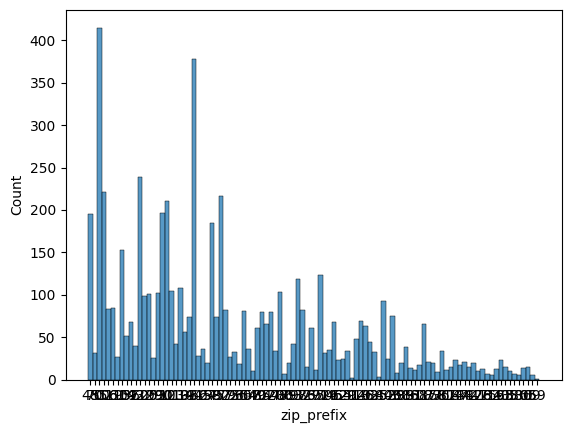

In [ ]:
sns.histplot(data = user_data_df, x = 'zip_prefix')

In [ ]:
user_data_df.zip_prefix.value_counts()

55    415
94    378
60    239
02    221
92    217
     ... 
86      5
09      5
25      3
51      2
69      1
Name: zip_prefix, Length: 100, dtype: int64

In [ ]:
movie_data_df = pd.read_csv(MOVIE_DATA, sep = '::', header=None, encoding='latin-1').set_axis(['item', 'title', 'genre'], axis = 1, inplace = False)
movie_data_df["release"] = movie_data_df["title"].apply(lambda x: x.split('(')[-1].split(')')[0]).astype("int")
movie_data_df["title"] = movie_data_df["title"].apply(lambda x: x.split('(')[0])
movie_data_df['genre'] = movie_data_df.genre.str.split("|")
genres = movie_data_df.genre.explode().astype('category').cat.categories.to_list()
genres_dict = {k:i for i,k in enumerate(genres)}
movie_data_df['genre_cat'] = movie_data_df.genre.apply(lambda x: [genres_dict[k] for k in x])
min_year = movie_data_df.release.min()
max_year = movie_data_df.release.max()
movie_data_df['release_year_norm'] = movie_data_df.release.apply(lambda x: (x-min_year) / (max_year - min_year))
movie_data_df['release_year_sqrt'] = movie_data_df.release_year_norm.apply(np.sqrt)
movie_data_df['release_year_sq'] = movie_data_df.release_year_norm.apply(lambda x: x**2)
movie_data_df

/tmp/ipykernel_613/2077648054.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movie_data_df = pd.read_csv(MOVIE_DATA, sep = '::', header=None, encoding='latin-1').set_axis(['item', 'title', 'genre'], axis = 1, inplace = False)
/tmp/ipykernel_613/2077648054.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  movie_data_df = pd.read_csv(MOVIE_DATA, sep = '::', header=None, encoding='latin-1').set_axis(['item', 'title', 'genre'], axis = 1, inplace = False)


,item,title,genre,release,genre_cat,release_year_norm,release_year_sqrt,release_year_sq
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,"[2, 3, 4]",0.938272,0.968644,0.880354
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995,"[1, 3, 8]",0.938272,0.968644,0.880354
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,"[4, 13]",0.938272,0.968644,0.880354
3,4,Waiting to Exhale,"[Comedy, Drama]",1995,"[4, 7]",0.938272,0.968644,0.880354
4,5,Father of the Bride Part II,[Comedy],1995,[4],0.938272,0.968644,0.880354
...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000,[4],1.000000,1.000000,1.000000
3879,3949,Requiem for a Dream,[Drama],2000,[7],1.000000,1.000000,1.000000
3880,3950,Tigerland,[Drama],2000,[7],1.000000,1.000000,1.000000
3881,3951,Two Family House,[Drama],2000,[7],1.000000,1.000000,1.000000


In [ ]:
movie_data_df.genre_cat.apply(len).max()

6

In [ ]:

#my extension of the dataset class for pytorch's data loader.
class TrainDataset(TorchDataset):
    def __init__(self, item, rating, history, genre_cat, release_year_norm,
      release_year_sqrt, release_year_sq, label):
        super(TrainDataset, self).__init__()
        self.len = len(item)
        self.item = item
        self.rating = rating
        self.history = history
        self.genre_cat = genre_cat
        self.release_year_norm = release_year_norm
        self.release_year_sqrt = release_year_sqrt
        self.release_year_sq = release_year_sq
        self.label = label


    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        item = self.item[idx]
        rating = self.rating[idx]
        history = self.history[idx]
        genre_cat = self.genre_cat[idx]
        release_year_norm = self.release_year_norm[idx]
        release_year_sqrt = self.release_year_sqrt[idx]
        release_year_sq = self.release_year_sq[idx]
        label = self.label[idx]
        return item, rating, history, genre_cat, release_year_norm, release_year_sqrt, release_year_sq, label


def add_negative_examples(df, movie_data_df, num_negatives):
  new_df = []
  num_items = len(movie_data_df)
  for row in tqdm(df.iterrows()):
    row = row[1]
    row['label'] = 1
    new_df.append(row.values)
    new_row = row.copy()
    new_row['label'] = 0
    new_row['rating'] = 1
    for t in range(num_negatives):
      j = np.random.randint(num_items)
      while j == row['item']:
        j = np.random.randint(num_items)
      new_row['item'] = j
      new_df.append(new_row.to_list())
  mask = ['item', 'rating','history', 'genre_cat', 'release_year_norm', 'release_year_sqrt', 'release_year_sq','label']
  columns = df.columns
  new_df = pd.DataFrame(new_df, columns = df.columns.to_list() + ['label']).merge(movie_data_df, how = 'left', on = 'item').loc[:,mask]
  new_df.genre_cat = new_df.genre_cat.apply(lambda x: x if isinstance(x,list) else [])
  max_genres = movie_data_df.genre_cat.apply(len).max()
  new_df.genre_cat = new_df.genre_cat.apply(lambda arr:  arr + (max_genres - len(arr)) * [0])
  return  new_df

def df2ds(df):
  return TrainDataset(
  df.item.to_list(), 
  df.rating.to_list(),
  df.history.to_list(),
  df.genre_cat.to_list(),
  df.release_year_norm.to_list(),
  df.release_year_sqrt.to_list(),
  df.release_year_sq.to_list(),
  df.label.to_list()
  )




In [ ]:
# run first time for creating dataset with negative examples and save it to csv
#train = add_negative_examples(df, movie_data_df, 4)
#train.to_csv("train.csv")

In [ ]:
print("creating negative exampels")
train = add_negative_examples(df, movie_data_df, 4)
print("cleaning data")
train.fillna(0, inplace = True)
print("creating dataset")
train = df2ds(train)

creating negative exampels


994168it [07:29, 2214.14it/s]


cleaning data
creating dataset


In [ ]:
test = pd.read_csv(TEST, sep = '\t').set_axis(labels = ['user', 'item', 'rating', 'timestamp'], axis = 1)
test['label'] = 1
negatives = []
with open(NEG, "r") as f:
    for row in f.readlines():
        row = row.split("\t")
        user, real_item = eval(row[0])
        row = row[1:]
        [negatives.append([user, int(item), 0]) for item in row]
neg_df = pd.DataFrame(negatives, columns = ['user', 'item','label'])
test_df = pd.concat([test[['user', 'item','label']], neg_df])
temp_df = df.merge(df.groupby('user')['timestamp'].max().rename('max_timestamp'), left_on = 'user', right_index= True)
user_history = temp_df.loc[temp_df.timestamp == temp_df.max_timestamp].drop_duplicates(subset = ['user', 'timestamp'], keep = 'last')[['user','history']]
test_df = test_df.merge(user_history, on = 'user', how = 'left')
movie_mask = ['item', 'genre_cat', 'release_year_norm', 'release_year_sqrt', 'release_year_sq']
test_df = test_df.merge(movie_data_df[movie_mask], on = 'item')
test_df.genre_cat = test_df.genre_cat.apply(lambda x: x if isinstance(x,list) else [])
max_genres = movie_data_df.genre_cat.apply(len).max()
test_df.genre_cat = test_df.genre_cat.apply(lambda arr:  arr + (max_genres - len(arr)) * [0])
test_df['rating'] = 1
test_df.sort_values('user')
test_ds = df2ds(test_df)

,user,item,label,history,genre_cat,release_year_norm,release_year_sqrt,release_year_sq,rating
304779,0,3352,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 0, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
305271,0,1721,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 13, 0, 0, 0, 0]",0.962963,0.981307,0.927298,1
305436,0,3512,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 13, 0, 0, 0, 0]",1.000000,1.000000,1.000000,1
305619,0,3656,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[5, 0, 0, 0, 0, 0]",0.345679,0.587945,0.119494,1
305794,0,998,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[0, 5, 0, 0, 0, 0]",0.950617,0.974996,0.903673,1
...,...,...,...,...,...,...,...,...,...
194440,6039,1826,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[1, 3, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
476027,6039,3019,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[5, 7, 0, 0, 0, 0]",0.864198,0.929622,0.746837,1
35712,6039,2199,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[5, 7, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
253769,6039,1006,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[7, 0, 0, 0, 0, 0]",0.950617,0.974996,0.903673,1


# Watch history based candidate generation

- build model for training embeddings
- buid collabrative filtering inference
- build test and metrics for the first network

## Ranking

In [ ]:
batch_size = 1024
lr = 1e-2
reg = 1e-3
item_embed_dim = 16
cat_embed_dim = 8
relu_layers_dims = [64, 32, 16]

trainloader = DataLoader(train, batch_size = batch_size, shuffle = False)

num_items = len(movie_data_df)
num_categories = len(genres) 
cont_features = ['release_year_norm', 'release_year_sqrt', 'release_year_sq']
num_cont_features = len(cont_features)

class RankingNetwork(nn.Module):
    def __init__(self, item_embed_dim, cat_embed_dim):
        super(RankingNetwork, self).__init__()
        self.item_embed = Embedding(num_items, item_embed_dim)
        self.cat_embed = Embedding(num_categories, cat_embed_dim)
        fc1_in = 2 * item_embed_dim + cat_embed_dim + num_cont_features
        self.fc1 = Linear(in_features= fc1_in, out_features= relu_layers_dims[0])
        self.fc2 = Linear(in_features = relu_layers_dims[0], out_features = relu_layers_dims[1])
        self.fc3 = Linear(in_features = relu_layers_dims[1], out_features= relu_layers_dims[2])
        self.out = Linear(in_features = relu_layers_dims[2], out_features = 1)

    def evaluate_test(self, test_ds, criterion):
        item_test = torch.tensor(test_ds.item).to(device)
        rating_test = torch.tensor(test_ds.rating).to(device)
        history_test = torch.stack([torch.tensor(x) for x in test_ds.history]).to(device)
        genre_cat_test = torch.stack([torch.tensor(x) for x in test_ds.genre_cat]).to(device)
        release_year_norm_test = torch.tensor(test_ds.release_year_norm).to(device)
        release_year_sq_test = torch.tensor(test_ds.release_year_sq).to(device)
        release_year_sqrt_test = torch.tensor(test_ds.release_year_sqrt).to(device)
        label_test = torch.tensor(test_ds.label).to(dtype = torch.float32, device = device)
        with torch.no_grad():
            pred_test = self.forward(item_test, 
                            history_test, 
                            genre_cat_test, 
                            release_year_norm_test, 
                            release_year_sqrt_test,
                            release_year_sq_test,
                            rating_test)
        test_loss = criterion(torch.squeeze(pred_test), label_test)/len(test_ds.label)
        print(test_loss)
        return test_loss
    
    def forward(self, item, watch_history, genres, release_year_norm, release_year_sqrt, release_year_sq, rating):
        # get embeddings
        item_vector = self.item_embed(item.type(torch.int64))
        watch_history_vec = torch.mean(self.item_embed(watch_history), axis = 1)
        cat_vec = torch.mean(self.cat_embed(genres), axis = 1)

        # vector of continuos features
        cont_features_vector = torch.transpose(torch.stack([release_year_norm, release_year_sqrt, release_year_sq]), 1, 0)

        # stack all vectors to one
        x = torch.concat([item_vector, watch_history_vec, cat_vec, cont_features_vector], axis = 1).type(torch.float32)

        # propagate through network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        # non weighted logistic regression
        x = torch.squeeze(x)# * rating

        #return F.sigmoid(torch.mul(rating, torch.squeeze(self.out(x))))
        return torch.sigmoid(x)
    
    def train(self, train_data, lr, reg, epochs, test):
            self.train_time = time()
            self.loss_history = []
            self.test_loss_history = []
            criterion = nn.BCELoss(reduction='sum')
            optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg)
            loss_norm_factor = len(train_data.label)
            for epoch in range(epochs):
                epoch_loss = 0
                for i, batch in enumerate(tqdm(trainloader)):
                    item, rating, history, genre_cat, release_year_norm, release_year_sqrt, release_year_sq, label = batch
                    item = item.to(device)
                    rating = rating.to(device)
                    history = torch.transpose(torch.stack(history), 1, 0).to(device)
                    genre_cat = torch.transpose(torch.stack(genre_cat), 1, 0).to(device)
                    release_year_norm = release_year_norm.to(device)
                    release_year_sq = release_year_sq.to(device)
                    release_year_sqrt = release_year_sqrt.to(device)
                    label = label.to(dtype = torch.float32, device = device)
                    #reset grad
                    optimizer.zero_grad()

                    #forward and backward pass
                    pred = self.forward(item, 
                                        history, 
                                        genre_cat, 
                                        release_year_norm, 
                                        release_year_sqrt,
                                        release_year_sq,
                                        rating)
                    
                
                    loss = criterion(torch.squeeze(pred), label)
                    epoch_loss += loss / loss_norm_factor
                    
                    loss.backward()
                    optimizer.step()
                    
                self.loss_history.append(epoch_loss)
                test_loss = self.evaluate_test(test, criterion)
                self.test_loss_history.append(test_loss)
                print(f"epoch {epoch} loss: {epoch_loss} validation: {test_loss}")
            self.train_time = time() - self.train_time


ranking_nw = RankingNetwork(item_embed_dim, cat_embed_dim)
ranking_nw = ranking_nw.to(device)
print(ranking_nw)



RankingNetwork(
  (item_embed): Embedding(3883, 16)
  (cat_embed): Embedding(18, 8)
  (fc1): Linear(in_features=43, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
epochs = 10
ranking_nw.train(train, lr, reg, epochs, test_ds)

  5%|▍         | 229/4855 [00:03<01:18, 58.70it/s]


KeyboardInterrupt: 

## SQRT Weighted Ranking

In [ ]:
batch_size = 1024
lr = 1e-2
reg = 1e-3
item_embed_dim = 16
cat_embed_dim = 8
relu_layers_dims = [64, 32, 16]

trainloader = DataLoader(train, batch_size = batch_size, shuffle = False)

num_items = len(movie_data_df)
num_categories = len(genres) 
cont_features = ['release_year_norm', 'release_year_sqrt', 'release_year_sq']
num_cont_features = len(cont_features)

class RankingNetworkSQRT(nn.Module):
    def __init__(self, item_embed_dim, cat_embed_dim):
        super(RankingNetworkSQRT, self).__init__()
        self.item_embed = Embedding(num_items, item_embed_dim)
        self.cat_embed = Embedding(num_categories, cat_embed_dim)
        fc1_in = 2 * item_embed_dim + cat_embed_dim + num_cont_features
        self.fc1 = Linear(in_features= fc1_in, out_features= relu_layers_dims[0])
        self.fc2 = Linear(in_features = relu_layers_dims[0], out_features = relu_layers_dims[1])
        self.fc3 = Linear(in_features = relu_layers_dims[1], out_features= relu_layers_dims[2])
        self.out = Linear(in_features = relu_layers_dims[2], out_features = 1)

    def forward(self, item, watch_history, genres, release_year_norm, release_year_sqrt, release_year_sq, rating):
        # get embeddings
        item_vector = self.item_embed(item.type(torch.int64))
        watch_history_vec = torch.mean(self.item_embed(watch_history), axis = 1)
        cat_vec = torch.mean(self.cat_embed(genres), axis = 1)

        # vector of continuos features
        cont_features_vector = torch.transpose(torch.stack([release_year_norm, release_year_sqrt, release_year_sq]), 1, 0)

        # stack all vectors to one
        x = torch.concat([item_vector, watch_history_vec, cat_vec, cont_features_vector], axis = 1).type(torch.float32)

        # propagate through network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        # weighted logistic regression
        x = torch.squeeze(x) * torch.sqrt(rating)

        #return F.sigmoid(torch.mul(rating, torch.squeeze(self.out(x))))
        return torch.sigmoid(x)
    
    def train(self, train_data, lr, reg, epochs):
        self.train_time = time()
        self.loss_history = []
        criterion = nn.BCELoss(reduction='sum')
        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg)
        loss_norm_factor = len(train_data.label)
        for epoch in range(epochs):
            epoch_loss = 0
            for i, batch in enumerate(tqdm(trainloader)):
                item, rating, history, genre_cat, release_year_norm, release_year_sqrt, release_year_sq, label = batch
                item = item.to(device)
                rating = rating.to(device)
                history = torch.transpose(torch.stack(history), 1, 0).to(device)
                genre_cat = torch.transpose(torch.stack(genre_cat), 1, 0).to(device)
                release_year_norm = release_year_norm.to(device)
                release_year_sq = release_year_sq.to(device)
                release_year_sqrt = release_year_sqrt.to(device)
                label = label.to(dtype = torch.float32, device = device)
                #reset grad
                optimizer.zero_grad()

                #forward and backward pass
                pred = self.forward(item, 
                                    history, 
                                    genre_cat, 
                                    release_year_norm, 
                                    release_year_sqrt,
                                    release_year_sq,
                                    rating)
                
               
                loss = criterion(torch.squeeze(pred), label)
                epoch_loss += loss / loss_norm_factor
                
                loss.backward()
                optimizer.step()
                
            self.loss_history.append(epoch_loss)
            print(f"epoch {epoch} loss: {epoch_loss}")
        self.train_time = time() - self.train_time

ranking_nw_sqrt = RankingNetworkSQRT(item_embed_dim, cat_embed_dim)
ranking_nw_sqrt = ranking_nw_sqrt.to(device)
print(ranking_nw_sqrt)




RankingNetworkSQRT(
  (item_embed): Embedding(3883, 16)
  (cat_embed): Embedding(18, 8)
  (fc1): Linear(in_features=43, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
ranking_nw_sqrt.train(train, lr, reg, epochs = 10)

100%|██████████| 4855/4855 [00:55<00:00, 87.46it/s] 


epoch 0 loss: 0.35627156496047974


100%|██████████| 4855/4855 [00:59<00:00, 82.25it/s]


epoch 1 loss: 0.2882542908191681


100%|██████████| 4855/4855 [00:54<00:00, 89.49it/s] 


epoch 2 loss: 0.27228108048439026


100%|██████████| 4855/4855 [00:51<00:00, 94.88it/s] 


epoch 3 loss: 0.2618778645992279


100%|██████████| 4855/4855 [00:56<00:00, 86.41it/s] 


epoch 4 loss: 0.2556156814098358


100%|██████████| 4855/4855 [00:57<00:00, 84.82it/s]


epoch 5 loss: 0.252231240272522


100%|██████████| 4855/4855 [00:52<00:00, 92.32it/s] 


epoch 6 loss: 0.25005221366882324


100%|██████████| 4855/4855 [00:44<00:00, 108.20it/s]


epoch 7 loss: 0.24840180575847626


100%|██████████| 4855/4855 [01:01<00:00, 78.31it/s] 


epoch 8 loss: 0.24712511897087097


100%|██████████| 4855/4855 [01:01<00:00, 78.88it/s] 

epoch 9 loss: 0.24609224498271942


# Improved Model - adding 1x1 Conv1d to the watch vector

In [ ]:
batch_size = 1024
lr = 1e-2
reg = 1e-3
item_embed_dim = 16
cat_embed_dim = 8
relu_layers_dims = [64, 32, 16]
window = 10

trainloader = DataLoader(train, batch_size = batch_size, shuffle = False)

num_items = len(movie_data_df)
num_categories = len(genres) 
cont_features = ['release_year_norm', 'release_year_sqrt', 'release_year_sq']
num_cont_features = len(cont_features)


class RankingNetworkWithConv(nn.Module):
    def __init__(self, item_embed_dim, cat_embed_dim, history_window_size):
        super(RankingNetworkWithConv, self).__init__()
        self.item_embed = Embedding(num_items, item_embed_dim)
        self.cat_embed = Embedding(num_categories, cat_embed_dim)
        self.conv = nn.Conv1d(in_channels = history_window_size, out_channels = 1, kernel_size = 1)
        fc1_in = 2 * item_embed_dim + cat_embed_dim + num_cont_features
        self.fc1 = Linear(in_features= fc1_in, out_features= relu_layers_dims[0])
        self.fc2 = Linear(in_features = relu_layers_dims[0], out_features = relu_layers_dims[1])
        self.fc3 = Linear(in_features = relu_layers_dims[1], out_features= relu_layers_dims[2])
        self.out = Linear(in_features = relu_layers_dims[2], out_features = 1)
    
    def evaluate_test(self, test_ds, criterion):
        item_test = torch.tensor(test_ds.item).to(device)
        rating_test = torch.tensor(test_ds.rating).to(device)
        history_test = torch.stack([torch.tensor(x) for x in test_ds.history]).to(device)
        genre_cat_test = torch.stack([torch.tensor(x) for x in test_ds.genre_cat]).to(device)
        release_year_norm_test = torch.tensor(test_ds.release_year_norm).to(device)
        release_year_sq_test = torch.tensor(test_ds.release_year_sq).to(device)
        release_year_sqrt_test = torch.tensor(test_ds.release_year_sqrt).to(device)
        label_test = torch.tensor(test_ds.label).to(dtype = torch.float32, device = device)
        with torch.no_grad():
            pred_test = self.forward(item_test, 
                            history_test, 
                            genre_cat_test, 
                            release_year_norm_test, 
                            release_year_sqrt_test,
                            release_year_sq_test,
                            rating_test)
        test_loss = criterion(torch.squeeze(pred_test), label_test)/len(test_ds.label)
        print(test_loss)
        return test_loss
    
    def forward(self, item, watch_history, genres, release_year_norm, release_year_sqrt, release_year_sq, rating):
        # get embeddings
        item_vector = self.item_embed(item.type(torch.int64))
        watch_history_vec = torch.squeeze(self.conv(self.item_embed(watch_history)))
        cat_vec = torch.mean(self.cat_embed(genres), axis = 1)

        # vector of continuos features
        cont_features_vector = torch.transpose(torch.stack([release_year_norm, release_year_sqrt, release_year_sq]), 1, 0)

        # stack all vectors to one
        x = torch.concat([item_vector, watch_history_vec, cat_vec, cont_features_vector], axis = 1).type(torch.float32)

        # propagate through network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)

        return torch.sigmoid(x)
    
    def train(self, train_data, lr, reg, epochs, test):
        self.train_time = time()
        self.loss_history = []
        self.test_loss_history = []
        criterion = nn.BCELoss(reduction='sum')
        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg)
        loss_norm_factor = len(train_data.label)
        for epoch in range(epochs):
            epoch_loss = 0
            for i, batch in enumerate(tqdm(trainloader)):
                item, rating, history, genre_cat, release_year_norm, release_year_sqrt, release_year_sq, label = batch
                item = item.to(device)
                rating = rating.to(device)
                history = torch.transpose(torch.stack(history), 1, 0).to(device)
                genre_cat = torch.transpose(torch.stack(genre_cat), 1, 0).to(device)
                release_year_norm = release_year_norm.to(device)
                release_year_sq = release_year_sq.to(device)
                release_year_sqrt = release_year_sqrt.to(device)
                label = label.to(dtype = torch.float32, device = device)
                #reset grad
                optimizer.zero_grad()

                #forward and backward pass
                pred = self.forward(item, 
                                    history, 
                                    genre_cat, 
                                    release_year_norm, 
                                    release_year_sqrt,
                                    release_year_sq,
                                    rating)
                
               
                loss = criterion(torch.squeeze(pred), label)
                epoch_loss += loss / loss_norm_factor
                
                loss.backward()
                optimizer.step()
                
            self.loss_history.append(epoch_loss)
            test_loss = self.evaluate_test(test, criterion)
            self.test_loss_history.append(test_loss)
            print(f"epoch {epoch} loss: {epoch_loss} validation: {test_loss}")

        self.train_time = time() - self.train_time

ranking_nw_conv = RankingNetworkWithConv(item_embed_dim, cat_embed_dim, window)
ranking_nw_conv = ranking_nw_conv.to(device)
print(ranking_nw_conv)



RankingNetworkWithConv(
  (item_embed): Embedding(3883, 16)
  (cat_embed): Embedding(18, 8)
  (conv): Conv1d(10, 1, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=43, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
ranking_nw_conv.train(train, lr, reg, epochs = 10, test = test_ds)

100%|██████████| 4855/4855 [00:54<00:00, 89.25it/s] 


tensor(0.1534, device='cuda:0')
epoch 0 loss: 0.309982031583786 validation: 0.15336811542510986


100%|██████████| 4855/4855 [00:56<00:00, 85.19it/s] 


tensor(0.1394, device='cuda:0')
epoch 1 loss: 0.2505602538585663 validation: 0.1393740177154541


100%|██████████| 4855/4855 [01:01<00:00, 78.63it/s] 


tensor(0.1319, device='cuda:0')
epoch 2 loss: 0.23279796540737152 validation: 0.1318787783384323


100%|██████████| 4855/4855 [00:54<00:00, 89.41it/s]


tensor(0.1368, device='cuda:0')
epoch 3 loss: 0.2230665385723114 validation: 0.13682609796524048


100%|██████████| 4855/4855 [00:56<00:00, 86.05it/s]


tensor(0.1265, device='cuda:0')
epoch 4 loss: 0.21839945018291473 validation: 0.12654182314872742


100%|██████████| 4855/4855 [00:53<00:00, 91.45it/s] 


tensor(0.1294, device='cuda:0')
epoch 5 loss: 0.21531569957733154 validation: 0.1293870061635971


100%|██████████| 4855/4855 [00:55<00:00, 87.03it/s] 


tensor(0.1207, device='cuda:0')
epoch 6 loss: 0.2129671424627304 validation: 0.12069719284772873


100%|██████████| 4855/4855 [01:02<00:00, 77.12it/s]


tensor(0.1196, device='cuda:0')
epoch 7 loss: 0.2114969938993454 validation: 0.11963808536529541


100%|██████████| 4855/4855 [00:59<00:00, 81.85it/s]


tensor(0.1248, device='cuda:0')
epoch 8 loss: 0.21047009527683258 validation: 0.12484460324048996


100%|██████████| 4855/4855 [00:53<00:00, 90.12it/s] 


tensor(0.1339, device='cuda:0')
epoch 9 loss: 0.20991666615009308 validation: 0.13391928374767303


In [ ]:
list(ranking_nw_conv.conv.parameters())

[Parameter containing:
 tensor([[[-0.1433],
          [-0.1205],
          [-0.1333],
          [-0.1473],
          [-0.1768],
          [-0.2211],
          [-0.2406],
          [-0.3043],
          [-0.4323],
          [-0.6208]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0645], device='cuda:0', requires_grad=True)]

In [ ]:
ranking_nw_conv.loss_history

[tensor(0.2112, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2087, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2078, device='cuda:0', grad_fn=<AddBackward0>)]

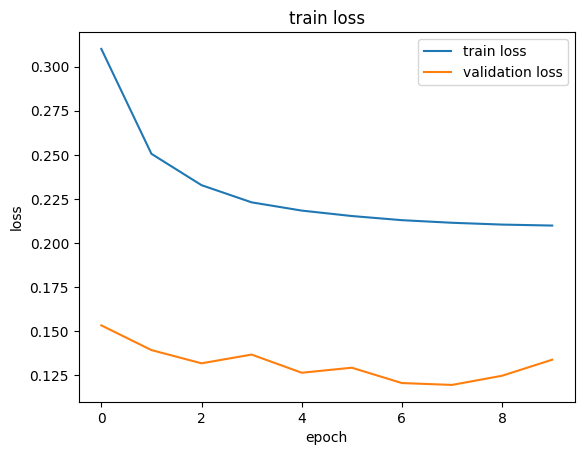

In [ ]:
train_loss = [x.detach().cpu().item() for x in ranking_nw_conv.loss_history]
val_loss = [x.detach().cpu().item() for x in ranking_nw_conv.test_loss_history]
plt.plot(np.arange(len(train_loss)), train_loss, label = 'train loss')
plt.plot(np.arange(len(val_loss)), val_loss, label = 'validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")
plt.legend()

# Evaluation

### Test Data Preprocessing

In [ ]:
test = pd.read_csv(TEST, sep = '\t').set_axis(labels = ['user', 'item', 'rating', 'timestamp'], axis = 1)
test['label'] = 1
negatives = []
with open(NEG, "r") as f:
    for row in f.readlines():
        row = row.split("\t")
        user, real_item = eval(row[0])
        row = row[1:]
        [negatives.append([user, int(item), 0]) for item in row]
neg_df = pd.DataFrame(negatives, columns = ['user', 'item','label'])
test_df = pd.concat([test[['user', 'item','label']], neg_df])
temp_df = df.merge(df.groupby('user')['timestamp'].max().rename('max_timestamp'), left_on = 'user', right_index= True)
user_history = temp_df.loc[temp_df.timestamp == temp_df.max_timestamp].drop_duplicates(subset = ['user', 'timestamp'], keep = 'last')[['user','history']]
test_df = test_df.merge(user_history, on = 'user', how = 'left')
movie_mask = ['item', 'genre_cat', 'release_year_norm', 'release_year_sqrt', 'release_year_sq']
test_df = test_df.merge(movie_data_df[movie_mask], on = 'item')
test_df.genre_cat = test_df.genre_cat.apply(lambda x: x if isinstance(x,list) else [])
max_genres = movie_data_df.genre_cat.apply(len).max()
test_df.genre_cat = test_df.genre_cat.apply(lambda arr:  arr + (max_genres - len(arr)) * [0])
test_df['rating'] = 1
test_df.sort_values('user')


,user,item,label,history,genre_cat,release_year_norm,release_year_sqrt,release_year_sq,rating
304779,0,3352,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 0, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
305271,0,1721,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 13, 0, 0, 0, 0]",0.962963,0.981307,0.927298,1
305436,0,3512,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[7, 13, 0, 0, 0, 0]",1.000000,1.000000,1.000000,1
305619,0,3656,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[5, 0, 0, 0, 0, 0]",0.345679,0.587945,0.119494,1
305794,0,998,0,"[28, 23, 29, 33, 40, 10, 16, 4, 35, 30]","[0, 5, 0, 0, 0, 0]",0.950617,0.974996,0.903673,1
...,...,...,...,...,...,...,...,...,...
194440,6039,1826,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[1, 3, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
476027,6039,3019,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[5, 7, 0, 0, 0, 0]",0.864198,0.929622,0.746837,1
35712,6039,2199,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[5, 7, 0, 0, 0, 0]",0.975309,0.987577,0.951227,1
253769,6039,1006,0,"[1535, 693, 289, 509, 151, 203, 1033, 1272, 16...","[7, 0, 0, 0, 0, 0]",0.950617,0.974996,0.903673,1


In [ ]:
complete_test = test_df.merge(test[['user','item','rating']].set_axis(labels =['user','item', 'actual_rating'], axis = 1), on = ['user','item'], how = 'left')
complete_test

,user,item,label,history,genre_cat,release_year_norm,release_year_sqrt,release_year_sq,rating,actual_rating
0,1,133,1,"[98, 60, 91, 126, 163, 73, 79, 130, 86, 66]","[4, 7, 0, 0, 0, 0]",0.938272,0.968644,0.880354,1,3.0
1,1613,133,1,"[605, 455, 86, 58, 72, 1265, 656, 954, 1103, 1...","[4, 7, 0, 0, 0, 0]",0.938272,0.968644,0.880354,1,2.0
2,2345,133,1,"[1868, 137, 58, 86, 163, 1058, 1482, 1665, 125...","[4, 7, 0, 0, 0, 0]",0.938272,0.968644,0.880354,1,4.0
3,3819,133,1,"[586, 322, 989, 1014, 1005, 60, 663, 591, 775,...","[4, 7, 0, 0, 0, 0]",0.938272,0.968644,0.880354,1,4.0
4,4132,133,1,"[189, 195, 58, 630, 202, 782, 1685, 185, 653, ...","[4, 7, 0, 0, 0, 0]",0.938272,0.968644,0.880354,1,4.0
...,...,...,...,...,...,...,...,...,...,...
592889,5803,3113,0,"[44, 438, 2306, 1106, 1831, 2091, 425, 171, 27...","[0, 15, 0, 0, 0, 0]",0.987654,0.993808,0.975461,1,NaN
592890,5879,3113,0,"[1081, 1726, 1063, 1523, 2091, 1650, 2733, 999...","[0, 15, 0, 0, 0, 0]",0.987654,0.993808,0.975461,1,NaN
592891,5998,3113,0,"[338, 743, 995, 1446, 121, 945, 1450, 985, 311...","[0, 15, 0, 0, 0, 0]",0.987654,0.993808,0.975461,1,NaN
592892,6019,3113,0,"[212, 1475, 1704, 97, 189, 643, 64, 156, 1470,...","[0, 15, 0, 0, 0, 0]",0.987654,0.993808,0.975461,1,NaN


### Evaluation

In [ ]:
class Evaluation():
    def __init__(self, model, test, complete_test_df):
        self.test = test
        self.model = model
        test_ds = df2ds(complete_test_df)
        self.complete_test_df = complete_test_df.copy()
        item = torch.tensor(test_ds.item).to(device)
        rating = torch.tensor(test_ds.rating).to(device)
        history = torch.stack([torch.tensor(x) for x in test_ds.history]).to(device)
        genre_cat = torch.stack([torch.tensor(x) for x in test_ds.genre_cat]).to(device)
        release_year_norm = torch.tensor(test_ds.release_year_norm).to(device)
        release_year_sq = torch.tensor(test_ds.release_year_sq).to(device)
        release_year_sqrt = torch.tensor(test_ds.release_year_sqrt).to(device)
        label = torch.tensor(test_ds.label).to(dtype = torch.float32, device = device)
        with torch.no_grad():
            pred = model.forward(item, 
                            history, 
                            genre_cat, 
                            release_year_norm, 
                            release_year_sqrt,
                            release_year_sq,
                            rating)
        self.complete_test_df['score'] = pred.detach().cpu()
        self.complete_test_df = self.complete_test_df.sort_values(['user','score'], ascending = False)
        self.evaluations = {}

    
    def predict_for_user(self, user_idx, top_k):
        user_data = self.complete_test_df.loc[self.complete_test_df.user == user_idx]
        result = user_data.sort_values('score', ascending = False).item.to_numpy()[:top_k]
        return result

    def evaluate_model(self, top_k):
        for k in top_k:
            hits = []
            dcgs = []
            recip_ranks = []
            for user_idx, test_item in self.test[['user','item']].values:
                prediction = self.predict_for_user(user_idx, k)
                hit = test_item in prediction
                for i, item in enumerate(prediction):
                    if item == test_item:
                        dcg = np.log(2) / np.log(2 + i)
                        recip_rank = 1 / (i + 1)
                dcg = dcg if hit else 0
                rr = recip_rank if hit else 0
                hits.append(hit)
                dcgs.append(dcg)
                recip_ranks.append(rr)
            hit_ratio = np.mean(hits)
            mean_dcg = np.mean(dcgs)
            mrr = np.mean(recip_ranks)
            self.evaluations[f'HR@{k}'] = hit_ratio
            self.evaluations[f'NDCG@{k}'] = mean_dcg
            self.evaluations[f'MRR@{k}'] = mrr

    def plot_evaluations(self, top_k = [3,5,7,10], metrics = ['HR', 'NDCG', 'MRR']):
        if not np.all([f"HR@{k}" in self.evaluations for k in top_k]):
            self.evaluate_model(top_k)
        for metric in metrics:
            y = [self.evaluations[f"{metric}@{k}"] for k in top_k]
            plt.plot(top_k, y, label = metric)
            plt.xlabel("top k")
            plt.ylabel("metric score")
            plt.legend()
        


test_data = [test, complete_test]
models = {'Classic': [ranking_nw, Evaluation(ranking_nw, *test_data)],
          'RankingSQRT': [ranking_nw_sqrt, Evaluation(ranking_nw_sqrt, *test_data)],
          'WithConv': [ranking_nw_conv, Evaluation(ranking_nw_conv, *test_data)]
          }
top_k = [3, 5, 7, 8, 10]
metrics = ['HR', 'MRR', 'NDCG']
eval_df = []
columns = ['model name', 'k', 'metric', 'value']
for model_name,(model,evaluation) in tqdm(models.items()):
    evaluation.evaluate_model(top_k)
    loss = round(model.loss_history[-1].detach().cpu().item(),5)
    train_min = round(model.train_time / 60, 1)
    loss_history = [x.detach().cpu().item() for x in model.loss_history]
    eval_df.append([model_name, 0, 'loss history', loss_history])
    eval_df.append([model_name, 0, 'train time (minutes)', train_min])
    for metric in metrics:
        for k in top_k:
            eval_df.append([model_name, k, metric, evaluation.evaluations[f"{metric}@{k}"]])
eval_df = pd.DataFrame(eval_df, columns = columns)
eval_df

100%|██████████| 3/3 [01:57<00:00, 39.33s/it]


,model name,k,metric,value
0,Classic,0,loss history,"[0.31094449758529663, 0.2586010992527008, 0.24..."
1,Classic,0,train time (minutes),8.8
2,Classic,3,HR,0.461997
3,Classic,5,HR,0.555224
4,Classic,7,HR,0.613015
5,Classic,8,HR,0.637688
6,Classic,10,HR,0.68306
7,Classic,3,MRR,0.342579
8,Classic,5,MRR,0.363736
9,Classic,7,MRR,0.372722


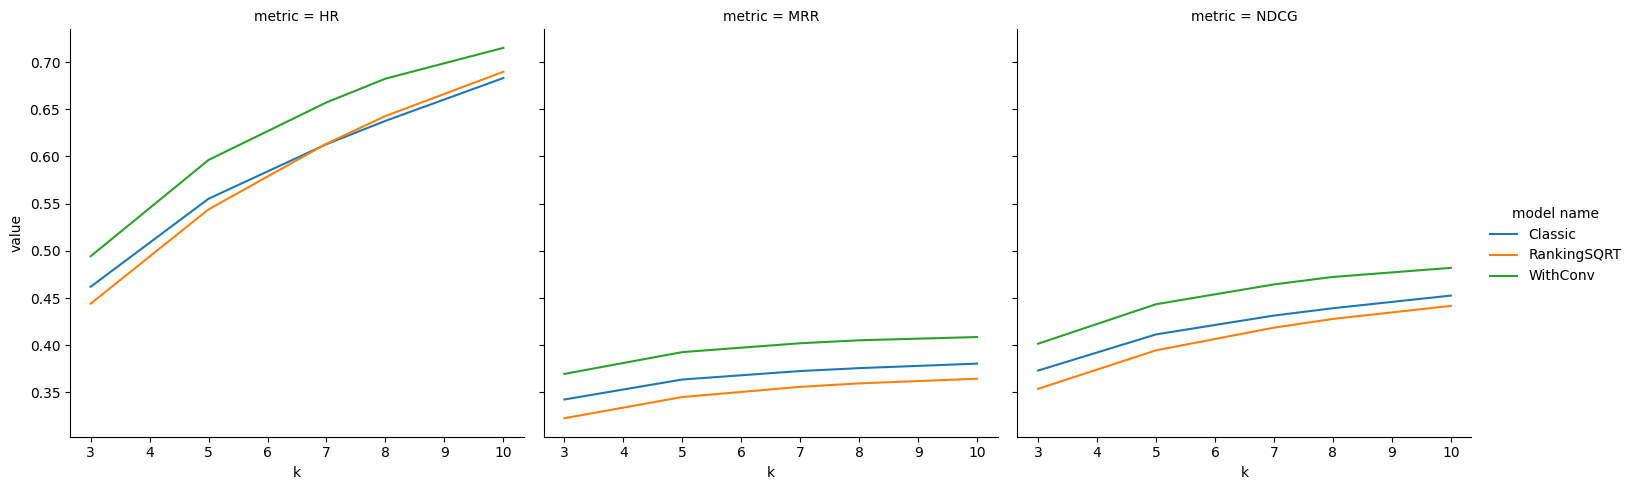

In [ ]:
fig = sns.relplot(data = eval_df.loc[eval_df.metric.apply(lambda x: x in metrics)],
        x = 'k', y = 'value', hue = 'model name', col = 'metric', kind = 'line')

plt.savefig("metric_top_k_no_conv.png", format = 'png')

<AxesSubplot: title={'center': 'time to train (minutes)'}, xlabel='model name'>

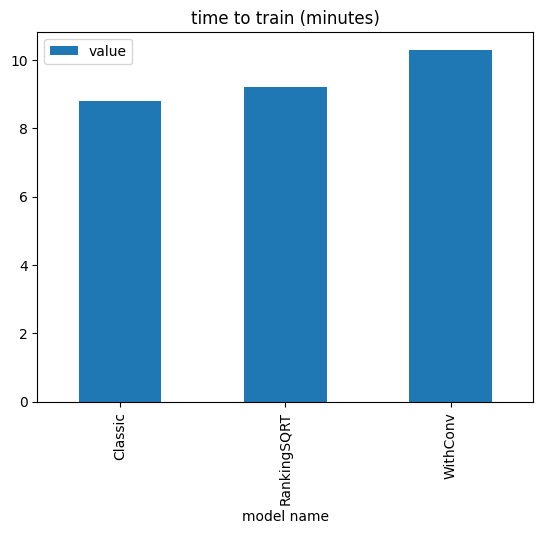

In [ ]:
eval_df.loc[eval_df.metric == 'train time (minutes)', ['model name', 'value']].plot.bar(x = 'model name', title = 'time to train (minutes)')

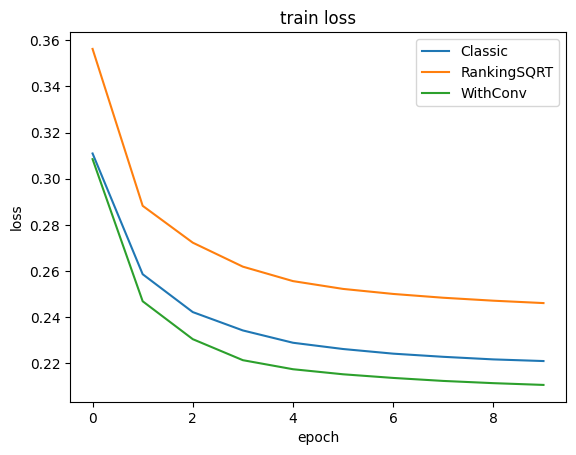

In [ ]:
loss_data = eval_df.loc[eval_df.metric == 'loss history', ['model name', 'value']]
for row in loss_data.iterrows():
    loss = row[1].value
    model = row[1]['model name']
    plt.plot(np.arange(len(loss)), loss, label = model)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")
plt.legend()

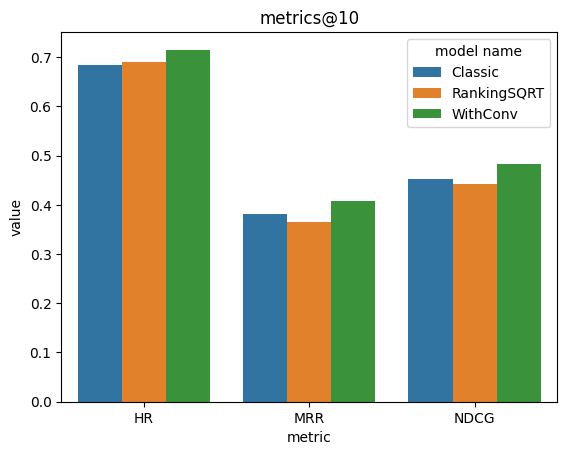

In [ ]:
mask = (eval_df.metric.apply(lambda x: x in metrics)) & (eval_df.k == 10)
ax  = sns.barplot(eval_df.loc[mask], x = 'metric', y = 'value', hue = 'model name')
_ = plt.title("metrics@10")

In [ ]:
hpt_table = []
columns = ['lr', 'categorical embedding dim', 'item embedding dim', 
           'training loss', 'test loss']
metrics = ['HR@10', 'MRR@10', 'NDCG@10', 'HR@5', 'MRR@5', 'NDCG@5']
columns.extend(metrics)
epochs = 10
reg = 1e-3
for lr in [0.01, 0.001]:
    for cat_embed_dim, item_embed_dim in [[16, 8],[32, 16]]:
        model = RankingNetwork(item_embed_dim, cat_embed_dim)
        model = model.to(device)
        model.train(train, lr, reg, epochs, test_ds)
        train_loss = model.loss_history[-1].detach().cpu().item()
        test_loss = model.test_loss_history[-1].detach().cpu().item()
        evaluation = Evaluation(model, test, complete_test)
        evaluation.evaluate_model(top_k = [5, 10])
        row = [lr, cat_embed_dim, item_embed_dim, train_loss, test_loss]
        row.extend([evaluation.evaluations[metric] for metric in metrics])
        hpt_table.append(row)

hpt_df = pd.DataFrame(hpt_table, columns = columns)
hpt_df

100%|██████████| 4855/4855 [00:52<00:00, 91.64it/s] 


tensor(0.1692, device='cuda:0')
epoch 0 loss: 0.32871559262275696 validation: 0.16918350756168365


100%|██████████| 4855/4855 [00:50<00:00, 96.44it/s] 


tensor(0.1539, device='cuda:0')
epoch 1 loss: 0.2720338702201843 validation: 0.15392588078975677


100%|██████████| 4855/4855 [00:49<00:00, 98.23it/s] 


tensor(0.1537, device='cuda:0')
epoch 2 loss: 0.25071921944618225 validation: 0.15373459458351135


100%|██████████| 4855/4855 [00:49<00:00, 98.45it/s] 


tensor(0.1477, device='cuda:0')
epoch 3 loss: 0.24428388476371765 validation: 0.14771616458892822


100%|██████████| 4855/4855 [00:49<00:00, 98.21it/s] 


tensor(0.1544, device='cuda:0')
epoch 4 loss: 0.2414831519126892 validation: 0.1544303596019745


100%|██████████| 4855/4855 [00:49<00:00, 97.72it/s] 


tensor(0.1525, device='cuda:0')
epoch 5 loss: 0.2397589087486267 validation: 0.15250852704048157


100%|██████████| 4855/4855 [00:48<00:00, 100.87it/s]


tensor(0.1524, device='cuda:0')
epoch 6 loss: 0.23876333236694336 validation: 0.15241576731204987


100%|██████████| 4855/4855 [00:47<00:00, 101.68it/s]


tensor(0.1522, device='cuda:0')
epoch 7 loss: 0.23774074018001556 validation: 0.15222899615764618


100%|██████████| 4855/4855 [00:47<00:00, 101.69it/s]


tensor(0.1485, device='cuda:0')
epoch 8 loss: 0.23706357181072235 validation: 0.14848069846630096


100%|██████████| 4855/4855 [00:47<00:00, 102.03it/s]


tensor(0.1483, device='cuda:0')
epoch 9 loss: 0.23646166920661926 validation: 0.14825597405433655


100%|██████████| 4855/4855 [00:48<00:00, 101.06it/s]


tensor(0.1815, device='cuda:0')
epoch 0 loss: 0.31856629252433777 validation: 0.1815081238746643


100%|██████████| 4855/4855 [00:48<00:00, 100.03it/s]


tensor(0.1498, device='cuda:0')
epoch 1 loss: 0.2590075433254242 validation: 0.1497739851474762


100%|██████████| 4855/4855 [00:54<00:00, 88.57it/s] 


tensor(0.1387, device='cuda:0')
epoch 2 loss: 0.24179194867610931 validation: 0.1387181431055069


100%|██████████| 4855/4855 [00:54<00:00, 89.20it/s] 


tensor(0.1232, device='cuda:0')
epoch 3 loss: 0.23263153433799744 validation: 0.12323803454637527


100%|██████████| 4855/4855 [01:03<00:00, 76.08it/s]


tensor(0.1286, device='cuda:0')
epoch 4 loss: 0.22769436240196228 validation: 0.12864038348197937


100%|██████████| 4855/4855 [00:56<00:00, 85.80it/s] 


tensor(0.1311, device='cuda:0')
epoch 5 loss: 0.22532890737056732 validation: 0.13114869594573975


100%|██████████| 4855/4855 [00:46<00:00, 104.34it/s]


tensor(0.1298, device='cuda:0')
epoch 6 loss: 0.22388191521167755 validation: 0.1297898292541504


100%|██████████| 4855/4855 [00:48<00:00, 100.69it/s]


tensor(0.1282, device='cuda:0')
epoch 7 loss: 0.22277623414993286 validation: 0.12822915613651276


100%|██████████| 4855/4855 [00:48<00:00, 100.18it/s]


tensor(0.1329, device='cuda:0')
epoch 8 loss: 0.22183583676815033 validation: 0.1329403519630432


100%|██████████| 4855/4855 [00:50<00:00, 96.40it/s] 


tensor(0.1305, device='cuda:0')
epoch 9 loss: 0.22123147547245026 validation: 0.13050726056098938


100%|██████████| 4855/4855 [00:55<00:00, 88.27it/s]


tensor(0.2231, device='cuda:0')
epoch 0 loss: 0.3954429626464844 validation: 0.22312568128108978


100%|██████████| 4855/4855 [00:53<00:00, 90.05it/s]


tensor(0.2138, device='cuda:0')
epoch 1 loss: 0.36032527685165405 validation: 0.21375496685504913


100%|██████████| 4855/4855 [00:54<00:00, 89.51it/s] 


tensor(0.1904, device='cuda:0')
epoch 2 loss: 0.3398239016532898 validation: 0.19041885435581207


100%|██████████| 4855/4855 [00:51<00:00, 94.25it/s] 


tensor(0.1835, device='cuda:0')
epoch 3 loss: 0.3257952034473419 validation: 0.18348665535449982


100%|██████████| 4855/4855 [00:56<00:00, 86.68it/s] 


tensor(0.1815, device='cuda:0')
epoch 4 loss: 0.31781673431396484 validation: 0.18149971961975098


100%|██████████| 4855/4855 [00:52<00:00, 92.02it/s] 


tensor(0.1821, device='cuda:0')
epoch 5 loss: 0.3121660649776459 validation: 0.18213079869747162


100%|██████████| 4855/4855 [00:59<00:00, 81.57it/s] 


tensor(0.1816, device='cuda:0')
epoch 6 loss: 0.30699867010116577 validation: 0.1816062331199646


100%|██████████| 4855/4855 [00:55<00:00, 87.98it/s] 


tensor(0.1807, device='cuda:0')
epoch 7 loss: 0.30221086740493774 validation: 0.18066951632499695


100%|██████████| 4855/4855 [00:53<00:00, 90.93it/s] 


tensor(0.1807, device='cuda:0')
epoch 8 loss: 0.2979799211025238 validation: 0.18068785965442657


100%|██████████| 4855/4855 [00:52<00:00, 91.81it/s]


tensor(0.1800, device='cuda:0')
epoch 9 loss: 0.2942572236061096 validation: 0.17997169494628906


100%|██████████| 4855/4855 [00:56<00:00, 85.76it/s] 


tensor(0.2019, device='cuda:0')
epoch 0 loss: 0.38222891092300415 validation: 0.20190824568271637


100%|██████████| 4855/4855 [00:51<00:00, 93.57it/s] 


tensor(0.1866, device='cuda:0')
epoch 1 loss: 0.3326992690563202 validation: 0.1866152286529541


100%|██████████| 4855/4855 [00:49<00:00, 99.06it/s] 


tensor(0.1777, device='cuda:0')
epoch 2 loss: 0.31370365619659424 validation: 0.17769691348075867


100%|██████████| 4855/4855 [00:51<00:00, 94.77it/s] 


tensor(0.1681, device='cuda:0')
epoch 3 loss: 0.3027626574039459 validation: 0.16813276708126068


100%|██████████| 4855/4855 [00:49<00:00, 97.16it/s] 


tensor(0.1639, device='cuda:0')
epoch 4 loss: 0.29331016540527344 validation: 0.16393308341503143


100%|██████████| 4855/4855 [00:52<00:00, 91.95it/s] 


tensor(0.1622, device='cuda:0')
epoch 5 loss: 0.28462138772010803 validation: 0.1621725708246231


100%|██████████| 4855/4855 [00:51<00:00, 93.59it/s] 


tensor(0.1584, device='cuda:0')
epoch 6 loss: 0.27592483162879944 validation: 0.1583634614944458


100%|██████████| 4855/4855 [00:52<00:00, 91.90it/s] 


tensor(0.1573, device='cuda:0')
epoch 7 loss: 0.2676234245300293 validation: 0.15727189183235168


100%|██████████| 4855/4855 [00:57<00:00, 84.60it/s]


tensor(0.1559, device='cuda:0')
epoch 8 loss: 0.26095935702323914 validation: 0.15589699149131775


100%|██████████| 4855/4855 [01:00<00:00, 80.45it/s] 


tensor(0.1560, device='cuda:0')
epoch 9 loss: 0.2559221684932709 validation: 0.1559605449438095


TypeError: DataFrame.__init__() got an unexpected keyword argument 'colulmns'

In [ ]:
pdb.pm()

> /tmp/ipykernel_613/4238480540.py(21)<module>()
     18         row.extend([evaluation.evaluations[metric] for metric in metrics])
     19         hpt_table.append(row)
     20 
---> 21 hpt_df = pd.DataFrame(hpt_table, colulmns = columns)
     22 hpt_df

[[0.01, 16, 8, 0.23646166920661926, 0.14825597405433655, 0.6661698956780924, 0.34963846111387104, 0.4249484967825396, 0.5325384997516145, 0.3316525914886571, 0.38157980876195474], [0.01, 32, 16, 0.22123147547245026, 0.13050726056098938, 0.6924987580725286, 0.3827998302042018, 0.45660858289382605, 0.5659877463156152, 0.3660484627697742, 0.41582967750669153], [0.001, 16, 8, 0.2942572236061096, 0.17997169494628906, 0.5696307335651598, 0.26014115918487507, 0.3328952176574326, 0.4134790528233151, 0.2393497819727328, 0.28244268897640534], [0.001, 32, 16, 0.2559221684932709, 0.1559605449438095, 0.6486173207484683, 0.32650628060464126, 0.40277961173015675, 0.5000827951647624, 0.3065601368880057, 0.35461940291986793]]
[[0.01, 16, 8, 0.23646166

In [ ]:
hpt_table = []
columns = ['lr', 'categorical embedding dim', 'item embedding dim', 
           'training loss', 'test loss']
metrics = ['HR@10', 'MRR@10', 'NDCG@10', 'HR@5', 'MRR@5', 'NDCG@5']
columns.extend(metrics)
epochs = 10
reg = 1e-3
for lr in [0.01]:
    for cat_embed_dim, item_embed_dim in [[16, 8],[32, 16]]:
        model = RankingNetworkWithConv(item_embed_dim, cat_embed_dim, window)
        model = model.to(device)
        model.train(train, lr, reg, epochs, test_ds)
        train_loss = model.loss_history[-1].detach().cpu().item()
        test_loss = model.test_loss_history[-1].detach().cpu().item()
        evaluation = Evaluation(model, test, complete_test)
        evaluation.evaluate_model(top_k = [5, 10])
        row = [lr, cat_embed_dim, item_embed_dim, train_loss, test_loss]
        row.extend([evaluation.evaluations[metric] for metric in metrics])
        hpt_table.append(row)

hpt_df = pd.DataFrame(hpt_table, columns = columns)
hpt_df

100%|██████████| 4855/4855 [01:02<00:00, 77.58it/s]


tensor(0.1626, device='cuda:0')
epoch 0 loss: 0.32745712995529175 validation: 0.1625814288854599


100%|██████████| 4855/4855 [01:06<00:00, 73.41it/s]


tensor(0.1590, device='cuda:0')
epoch 1 loss: 0.26897430419921875 validation: 0.1590164452791214


100%|██████████| 4855/4855 [00:58<00:00, 83.60it/s]


tensor(0.1468, device='cuda:0')
epoch 2 loss: 0.24769358336925507 validation: 0.14683657884597778


 18%|█▊        | 869/4855 [00:09<00:46, 85.55it/s]

In [ ]:
class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        # self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        # self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    

class MovieLensTestDataset(Dataset):

    def _init_(self,path):
        self.users, self.items, self.labels = self.get_dataset(path + ".test.negative")

    def _len_(self):
        return len(self.users)
  
    def get_data(self,idx):
        return self.users[idx*100:((idx+1)*100)], self.items[idx*100:((idx+1)*100)], self.labels[idx*100:((idx+1)*100)]

    def get_dataset(self, filename):
        users, items, labels = [], [], []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                first_tuple = arr[0][1:-1].split(",")
                u = int(first_tuple[0])
                i = int(first_tuple[1]) 
                users.append(u)
                items.append(i)
                labels.append(1)
                for negative_item in arr[1: ]:
                    users.append(u)
                    items.append(int(negative_item))
                    labels.append(0)
                line = f.readline()
        return np.array(users), np.array(items), np.array(labels)

dataset_test = MovieLensTestDataset(r'/content/neural_collaborative_filtering/Data/ml-1m')
dataset_test._init_(r'/content/neural_collaborative_filtering/Data/ml-1m')

In [ ]:
user_input = train.df['user'].values.tolist()
item_input = train.df['item'].values.tolist()
labels = train.df['label'].values.tolist()

num_users = len(set(user_input))
num_items = len(set(item_input))
num_factors = 8
learning_rate = 0.03

def get_MF_model(num_users, num_items, latent_dim):
    '''Vanilla Matrix Factorization'''
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    #prediction = merge([user_latent, item_latent], mode = 'dot')
    prediction = keras.layers.dot([user_latent,item_latent], axes=1,normalize=False)
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

mf_model = get_MF_model(num_users, num_items, num_factors)
mf_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

In [ ]:
import math
import heapq # for retrieval topK
import multiprocessing
from time import time
from tensorflow.keras.losses import BinaryCrossentropy

def evaluate_model(model, loss_func):
    mrr_5 = []
    ndcg_5 = []
    hr_5 = []
    mrr_10 = []
    ndcg_10 = []
    hr_10 = []
    # loss = []

    # users = test.df['user'].values.tolist()
    # items = test.df['item'].values.tolist()
    # test_labels = test.df['label'].values.tolist()
    
    users, items, test_labels = dataset_test.users,dataset_test.items,dataset_test.labels

    predictions = model.predict([np.array(users), np.array(items)], batch_size=100, verbose=0)
    # bce = BinaryCrossentropy()
    loss = 0
    if loss_func == 'bce':
      bce = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)
      loss = bce(np.float32(test_labels), predictions.squeeze()).numpy()
    if loss_func == 'mse':
      loss = tensorflow.keras.losses.mean_squared_error(np.float32(test_labels), predictions.squeeze()).numpy()

    for idx in range(num_users):
      map_item_score = {}
      user_prediction = predictions[(idx*100):((idx+1)*100)]
      user_items = items[(idx*100):((idx+1)*100)]
      # user_labels = labels[(idx*100):((idx+1)*100)]
      # loss.append(bce(user_labels, user_prediction).numpy())
      # loss.append(getBCE(user_labels, user_prediction))


      positive_item = user_items[0]
      for i in range(len(user_items)):
           item = user_items[i]
           map_item_score[item] = user_prediction[i] 

      # Evaluate top rank list
      ranklist_5 = heapq.nlargest(5, map_item_score, key=map_item_score.get)
      mrr_5.append(getMRR(ranklist_5, positive_item))
      ndcg_5.append(getNDCG(ranklist_5, positive_item))
      hr_5.append(getHitRatio(ranklist_5, positive_item))
      
      ranklist_10 = heapq.nlargest(10, map_item_score, key=map_item_score.get)
      mrr_10.append(getMRR(ranklist_10, positive_item))
      ndcg_10.append(getNDCG(ranklist_10, positive_item))
      hr_10.append(getHitRatio(ranklist_10, positive_item))

    return np.array(mrr_5).mean(),np.array(ndcg_5).mean(),np.array(hr_5).mean(), np.array(mrr_10).mean(), np.array(ndcg_10).mean(), np.array(hr_10).mean(),  loss

def getMRR(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return 1/(i+1)
    return 0

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [ ]:
def model_train(model_tup, loss_func, top_k = 10):
    model_name, model = model_tup
    mrr_5_list = []
    ndcg_5_list = []
    hr_5_list = []
    mrr_10_list = []
    ndcg_10_list = []
    hr_10_list = []
    loss_hist = []
    val_loss_hist = []
    best_mrr_10, best_ndcg_10, best_hr_10, best_iter = 0, 0, 0, 0

    epochs = 10
    t0 = time()
    print(f"Training {model_name} model")  
    for epoch in range(1,epochs+1):
        t1 = time()            
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                             np.array(labels), # labels 
                             batch_size=128, epochs=1, verbose=0, shuffle=True)
        t2 = time()
        print(f"Finished training epoch {epoch} in {t2-t1:.2f} seconds")            
            
        mrr_5, ndcg_5, hr_5, mrr_10, ndcg_10, hr_10, val_loss = evaluate_model(model, loss_func)
        loss = hist.history['loss'][0]

        mrr_5_list.append(mrr_5)
        ndcg_5_list.append(ndcg_5)
        hr_5_list.append(hr_5)
        mrr_10_list.append(mrr_10)
        ndcg_10_list.append(ndcg_10)
        hr_10_list.append(hr_10)
        loss_hist.append(loss)
        val_loss_hist.append(val_loss)

        print(f'Finished evaluating epoch {epoch} in {time()-t2:.1f} seconds\nMRR_10 = {mrr_10:.4f}, NDCG_10 = {ndcg_10:.4f}, HR_10 = {hr_10:.4f}, training loss = {loss:.4f}, test loss = {val_loss:.4f}')
        print(f'Finished evaluating epoch {epoch} in {time()-t2:.1f} seconds\nMRR_5 = {mrr_5:.4f}, NDCG_5 = {ndcg_5:.4f}, HR_5 = {hr_5:.4f}, training loss = {loss:.4f}, test loss = {val_loss:.4f}')


        if hr_10 > best_hr_10:
           best_mrr_10, best_ndcg_10, best_hr_10, best_iter = mrr_10, ndcg_10, hr_10, epoch
        elif epoch > 5 and hr_10 <= hr_10_list[-2]:
           print(f'Early stopping')
           break
            
    print(f"Best epoch was {best_iter}:  MRR_10 = {best_mrr_10:.4f}, NDCG_10 = {best_ndcg_10:.4f}, HR_10 = {best_hr_10:.4f}. ")

    return mrr_5_list, ndcg_5_list, hr_5_list, mrr_10_list, ndcg_10_list, hr_10_list, loss_hist, val_loss_hist, (time() - t0)

In [ ]:
def MF_hp_tune(lr_list, factor_list):
    best_HR_10 = 0
    for learning_rate in lr_list:
      for num_factors in factor_list:
        print(f'Training with parameters lr = {learning_rate}, num_factors = {num_factors}')
        model = get_MF_model(num_users, num_items, num_factors)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
        MF_mrr_5_list, MF_ndcg_5_list, MF_hr_5_list, MF_mrr_10_list, MF_ndcg_10_list, MF_hr_10_list, MF_loss_hist, MF_val_loss_hist, MF_time = model_train(('MF', model), 'bce')
        if max(MF_hr_10_list) > best_HR_10:
           best_HR_10 = max(MF_hr_10_list)
           print(f'Current best model parameters are lr = {learning_rate}, num_factors = {num_factors} with HR = {best_HR_10}')

MF_hp_tune([0.01, 0.001], [4, 8, 16])

Training with parameters lr = 0.001, num_factors = 4
Training MF model
Finished training epoch 1 in 81.79 seconds
Finished evaluating epoch 1 in 23.3 seconds
MRR_10 = 0.1382, NDCG_10 = 0.1984, HR_10 = 0.3995, training loss = 1.2357, test loss = 0.5355
Finished evaluating epoch 1 in 23.3 seconds
MRR_5 = 0.1162, NDCG_5 = 0.1444, HR_5 = 0.2311, training loss = 1.2357, test loss = 0.5355
Finished training epoch 2 in 80.27 seconds
Finished evaluating epoch 2 in 23.1 seconds
MRR_10 = 0.1451, NDCG_10 = 0.2055, HR_10 = 0.4058, training loss = 1.0689, test loss = 0.4136
Finished evaluating epoch 2 in 23.1 seconds
MRR_5 = 0.1237, NDCG_5 = 0.1536, HR_5 = 0.2454, training loss = 1.0689, test loss = 0.4136
Finished training epoch 3 in 143.20 seconds
Finished evaluating epoch 3 in 23.2 seconds
MRR_10 = 0.1481, NDCG_10 = 0.2119, HR_10 = 0.4232, training loss = 1.1473, test loss = 0.3566
Finished evaluating epoch 3 in 23.2 seconds
MRR_5 = 0.1265, NDCG_5 = 0.1591, HR_5 = 0.2588, training loss = 1.1473,

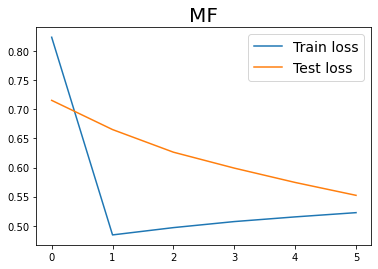

In [ ]:
MF_tup = ('MF', MF_mrr_5_list, MF_ndcg_5_list, MF_hr_5_list, MF_mrr_10_list, MF_ndcg_10_list, MF_hr_10_list, MF_loss_hist, MF_val_loss_hist, MF_time)
loss_plot = [[MF_tup[0], MF_tup[7], MF_tup[8]]]


# plot lines
plt.plot(loss_plot[0][1], label = 'Train loss')
plt.plot(loss_plot[0][2], label = 'Test loss')
plt.title(loss_plot[0][0], fontsize=20)

plt.legend(fontsize=14)
plt.show()